In [1]:
from IPython.display import display
from sympy import init_printing
init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
# import sympy as sp
import numpy as np
import pandas as pd
import uncertainties.unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
from auxiliares import *
from sympy.utilities.lambdify import lambdify
from scipy.odr import Model, RealData, ODR


In [3]:
u_term = combinada(utri(1), uret(0.6))
u_ohm = combinada(uret(2*(0.5 + 0.2)), uret(0.1))

In [4]:
fu_r_t = u_ohm

In [5]:
calib = pd.read_pickle('calib-ohm.df')

In [6]:
t = unp.uarray(calib["Temperatura"], calib["uT"])
r = unp.uarray(calib["Resistência"], calib["uRt"])

In [7]:
x = 1/(t+273)
y = unp.log(r)
dcalib = RealData(unp.nominal_values(x), unp.nominal_values(y), sx=unp.std_devs(x), sy=unp.std_devs(y))

In [8]:
mlinear = Model(lambda beta, x: beta[0]*x + beta[1])
myodr = ODR(dcalib, mlinear, beta0=[1., 1.], ndigit=20)

In [9]:
ajuste = myodr.run()
B, lnA = ajuste.beta
uB, ulnA = np.sqrt(np.diag(ajuste.cov_beta))
temperatura = vectorize(lambda raj : ufloat(B,uB)/(log(raj) - ufloat(lnA, ulnA)))
ajuste.pprint()

Beta: [3157.84755312   -6.38593272]
Beta Std Error: [32.19689415  0.10071502]
Beta Covariance: [[ 6.57251392e+02 -2.05337000e+00]
 [-2.05337000e+00  6.43120026e-03]]
Residual Variance: 1.5772351415139507
Inverse Condition #: 0.00015608710673484913
Reason(s) for Halting:
  Sum of squares convergence


In [12]:
np.e**(ufloat(lnA, ulnA))

0.0016850960324471121+/-0.0001351358795702574

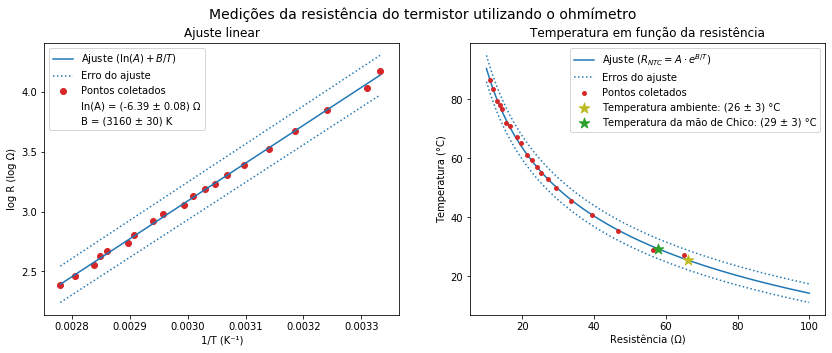

In [11]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("Medições da resistência do termistor utilizando o ohmímetro", fontsize=14)
ax = plt.subplot(1, 2, 1)
xs = np.linspace(min(unp.nominal_values(x)), max(unp.nominal_values(x)), 100)
ax.set_xlim(min(xs)*0.99, max(xs)*1.01)
ax.scatter(unp.nominal_values(x), unp.nominal_values(y), c='C3', label='Pontos coletados')
ax.plot(xs, B*xs + lnA, label='Ajuste ($\ln(A) + B/T$)')
ax.plot(xs, (B+uB)*xs + lnA + ulnA, ':', c='C0', label='Erro do ajuste')
ax.plot(xs, (B-uB)*xs + lnA - ulnA, ':', c='C0')
handles, labels = ax.get_legend_handles_labels()

handles.append(Patch(color='none', label=f'ln(A) = {sigdig(lnA, ulnA)} Ω'))
handles.append(Patch(color='none', label=f'B = {sigdig(B, uB)} K'))

ax.set_ylabel("log R (log Ω)")
ax.set_xlabel("1/T (K⁻¹)")
ax.set_title("Ajuste linear")
ax.legend(handles=handles)

ax = plt.subplot(1, 2, 2)
xs = np.linspace(10, 100, 100)
ys = temperatura(xs) - 273
ax.plot(xs, unp.nominal_values(ys), label='Ajuste ($R_{NTC} = A\\cdot e^{B/T}$)', zorder=-1)
ax.plot(xs, unp.nominal_values(ys) + unp.std_devs(ys), ':', c='C0', label='Erros do ajuste')
ax.plot(xs, unp.nominal_values(ys) - unp.std_devs(ys), ':', c='C0')
ax.scatter(calib["Resistência"], calib["Temperatura"], s=15, c='C3', label='Pontos coletados')

rs = [66.1, 57.7]
ts = [temperatura(ufloat(r, u_ohm))-273 for r in rs]

ax.scatter(rs[0], ts[0].n, s=120, c='C8', marker='*', label='Temperatura ambiente: '+sigdig(ts[0].n, ts[0].std_dev)+' °C')
ax.scatter(rs[1], ts[1].n, s=120, c='C2', marker='*', label='Temperatura da mão de Chico: '+sigdig(ts[1].n, ts[1].std_dev)+' °C')

ax.set_ylabel("Temperatura (°C)")
ax.set_xlabel("Resistência (Ω)")
ax.set_title("Temperatura em função da resistência")
ax.legend()

plt.savefig("ohm.png", dpi=400)
plt.show()
